In [ ]:
!pip install --quiet pandas matplotlib wordcloud konlpy

In [ ]:
# 1) 기본 라이브러리 및 설정
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
from matplotlib import font_manager

# (1) 한글 그래프 폰트 설정 (D2Coding)
plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False

# (2) WordCloud에서 사용할 한글 폰트 경로 자동 탐색 (D2Coding을 사용)
try:
    D2CODING_PATH = font_manager.findfont('D2Coding')
except:
    raise FileNotFoundError("시스템에서 폰트를 찾을 수 없습니다.")

# (3) Okt 토크나이저 초기화
okt = Okt()

# (4) 불용어 리스트 (inline 정의)
stopwords = {
    '동영상', '기사', '속보', '관련', '발표', '보도', '이번', '있다', '없다',
    '되다', '하다', '이번달', '내용', '위해'
}

# (5) 워드클라우드 기본 설정
WC_ARGS = {
    'font_path': D2CODING_PATH,
    'background_color': 'white',
    'width': 800,
    'height': 400,
    'max_words': 200,
    'colormap': 'tab10'
}


In [ ]:
# 2) 데이터 로드 및 전처리
df = pd.read_csv('articles.csv')

# (1) pub_datetime → datetime으로 변환
df['pub_datetime'] = pd.to_datetime(
    df['pub_datetime'],
    format='%Y-%m-%dT%H:%M:%S',
    errors='coerce'
)

# (2) 연–월(YYYY-MM) 추출
df['month'] = df['pub_datetime'].dt.to_period('M').astype(str)

# (3) section_code → 한글 섹션명 매핑
section_map = {100: '정치', 101: '경제', 102: '사회'}
df['section_code'] = df['section_code'].astype(int)
df['section'] = df['section_code'].map(section_map)

# (4) 매핑되지 않은 코드 확인 (선택)
missing = df[df['section'].isna()]['section_code'].unique()
if len(missing) > 0:
    print(f"Warning: 매핑되지 않은 section_code → {missing}")

df.sample(4)


url  \
1229123  https://n.news.naver.com/mnews/article/214/000...   
616018   https://n.news.naver.com/mnews/article/293/000...   
846094   https://n.news.naver.com/mnews/article/056/001...   
424374   https://n.news.naver.com/mnews/article/001/001...   

                                          title        pub_datetime  \
1229123                                   동영상기사 2025-05-04 07:02:00   
616018   [트럼프 쇼크] 두산밥캣, 멕시코 관세 '예의주시' 신규 M&A 승부 2025-02-17 14:29:00   
846094                                    동영상기사 2025-03-18 19:16:00   
424374      머스크의 DOGE 윤곽공개…백악관에 관리자·각부처에 4명 진단팀 2025-01-22 13:53:00   

         section_code    month section  
1229123           100  2025-05      정치  
616018            101  2025-02      경제  
846094            100  2025-03      정치  
424374            100  2025-01      정치

In [20]:
# 3) 전처리 함수 정의: 제목 → 명사 추출 → 불용어 제거
def preprocess_title(text):
    """
    1) okt.nouns()로 명사만 추출
    2) stopwords에 포함된 단어 제거
    3) 길이 1인 단어 제거
    """
    if not isinstance(text, str):
        return []
    nouns = okt.nouns(text)
    filtered = [w for w in nouns if (w not in stopwords) and (len(w) > 1)]
    return filtered


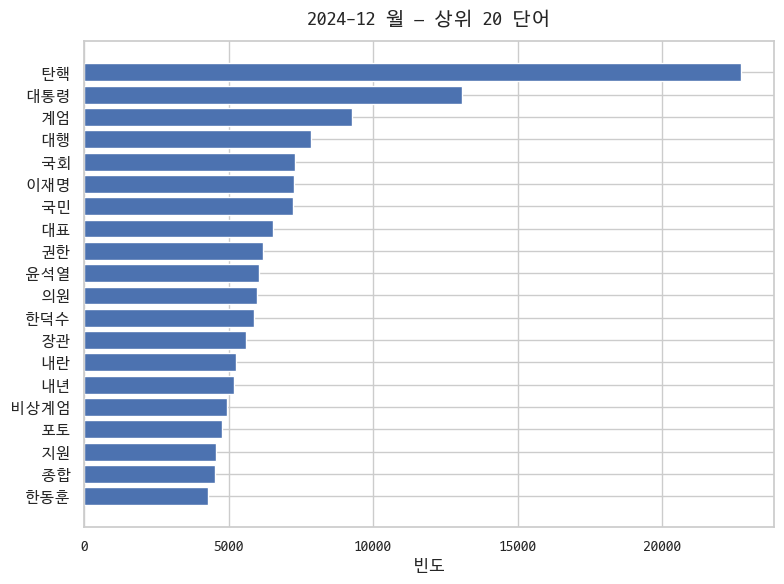

Saved ▶ barcharts/barchart_2024-12.png


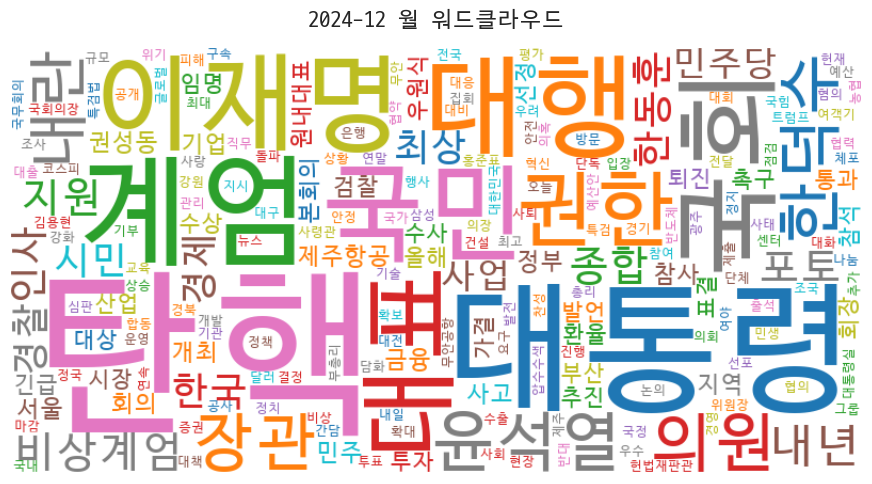

Saved ▶ wordclouds/wordcloud_2024-12.png


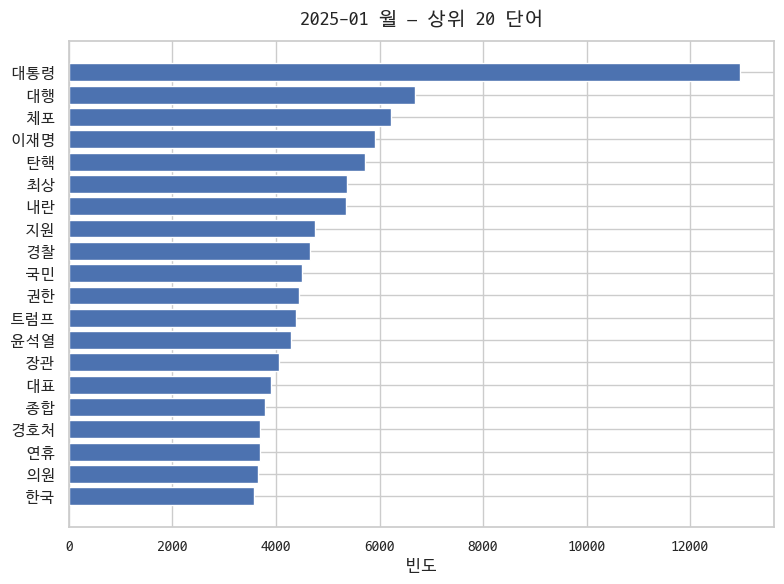

Saved ▶ barcharts/barchart_2025-01.png


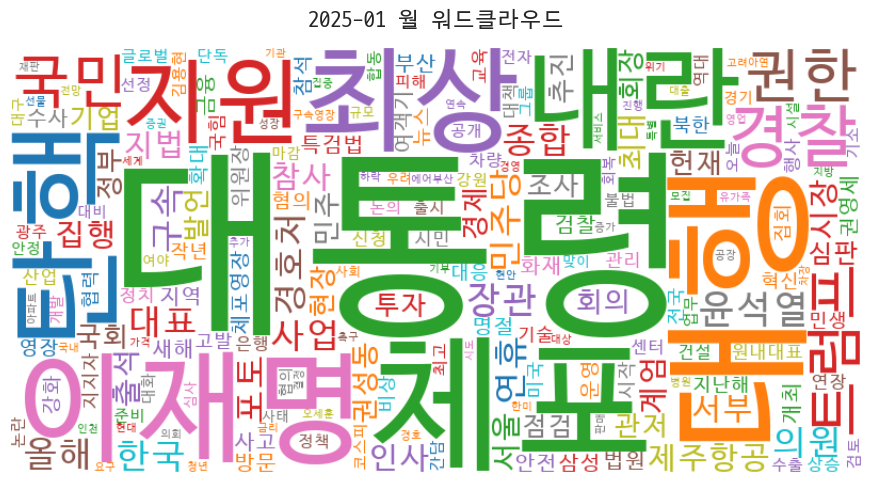

Saved ▶ wordclouds/wordcloud_2025-01.png


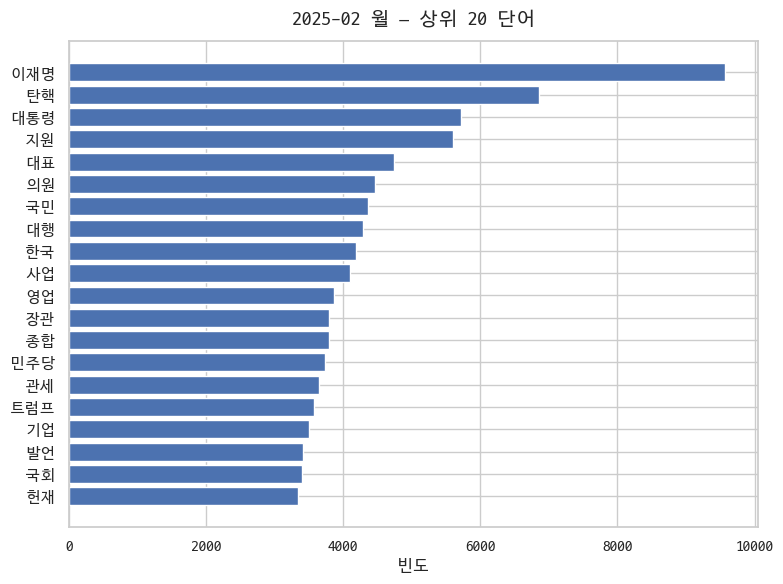

Saved ▶ barcharts/barchart_2025-02.png


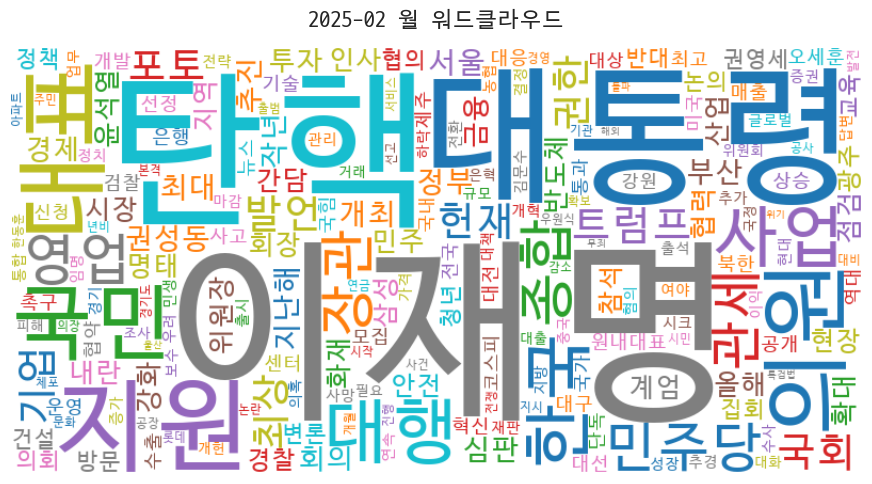

Saved ▶ wordclouds/wordcloud_2025-02.png


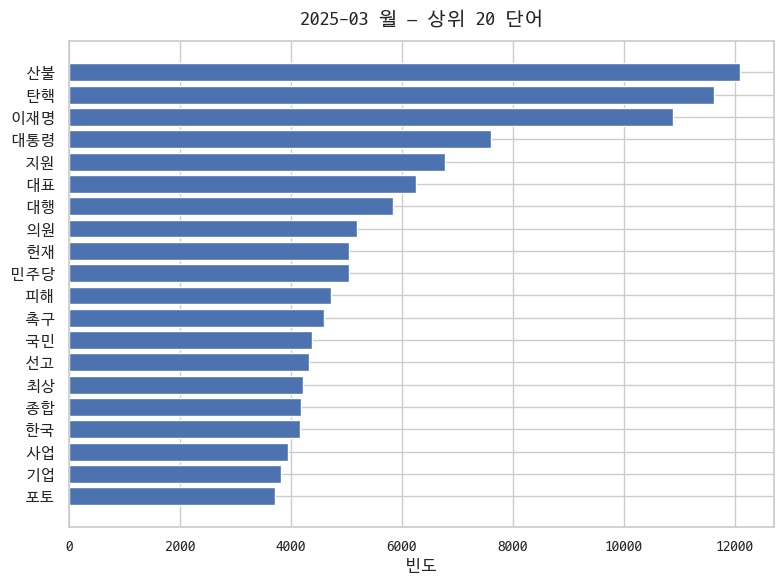

Saved ▶ barcharts/barchart_2025-03.png


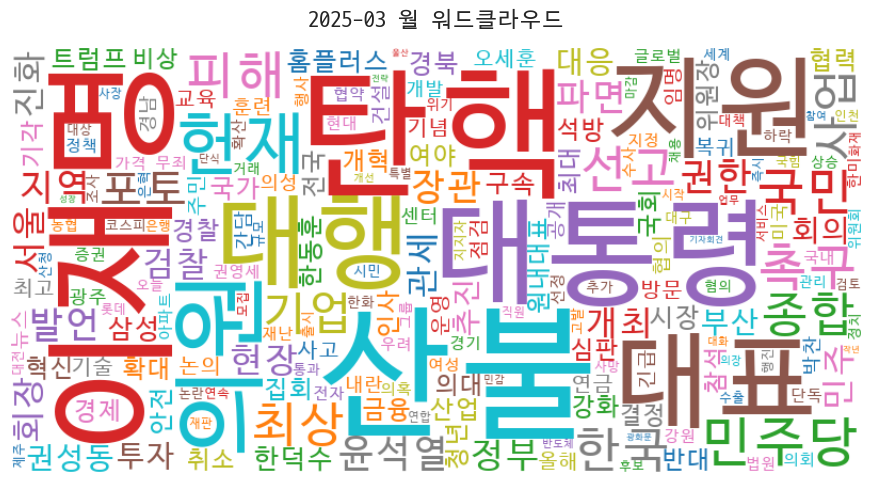

Saved ▶ wordclouds/wordcloud_2025-03.png


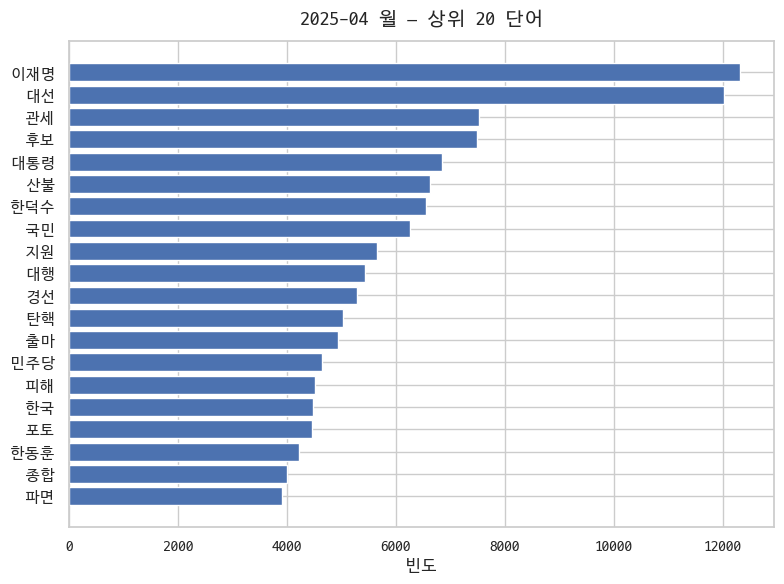

Saved ▶ barcharts/barchart_2025-04.png


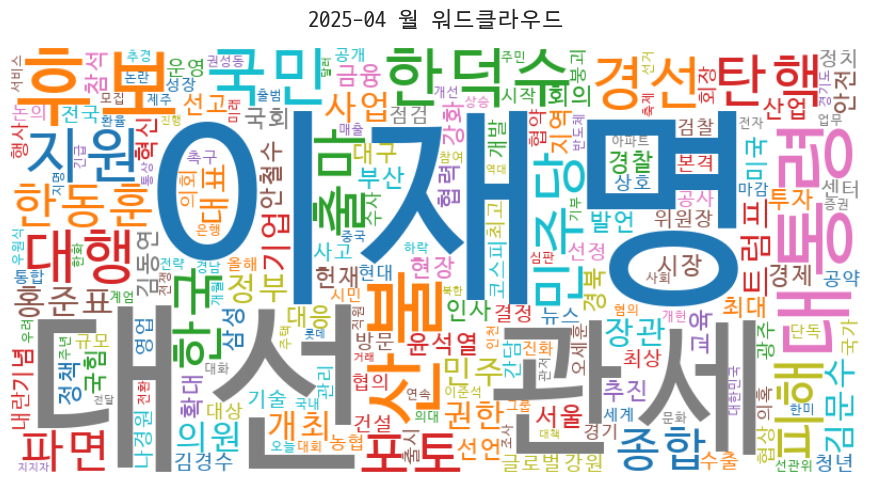

Saved ▶ wordclouds/wordcloud_2025-04.png


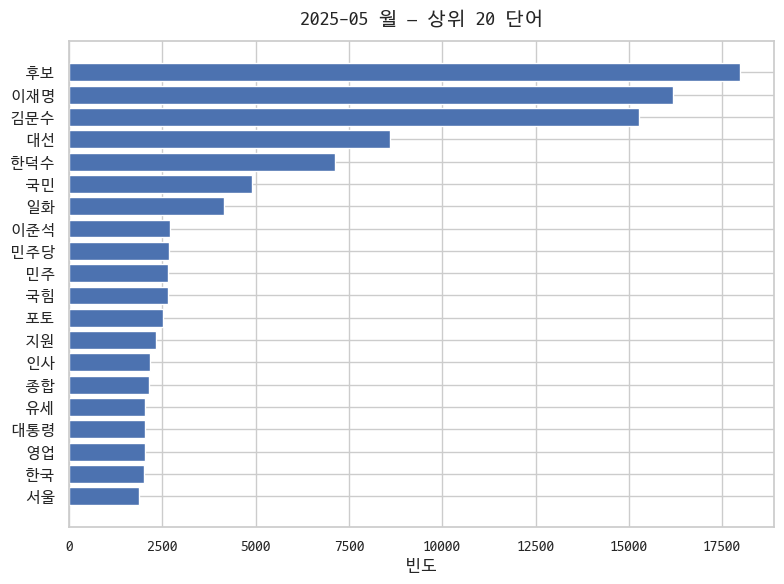

Saved ▶ barcharts/barchart_2025-05.png


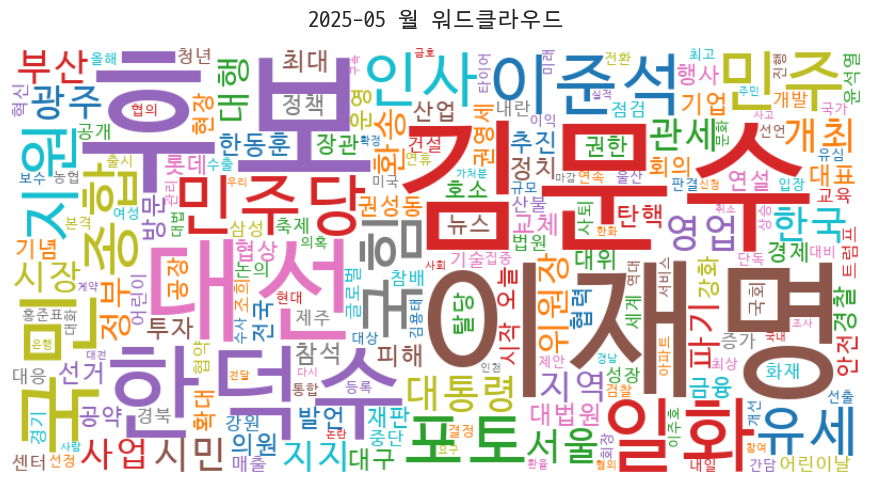

Saved ▶ wordclouds/wordcloud_2025-05.png


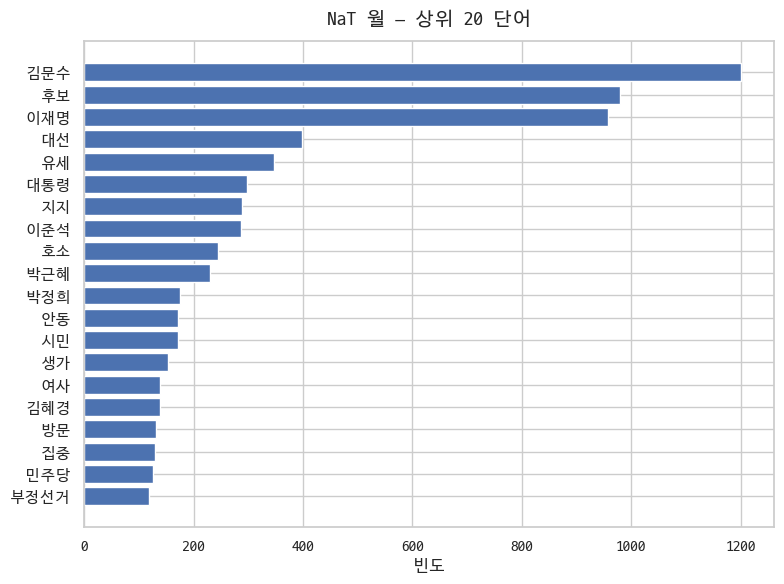

Saved ▶ barcharts/barchart_NaT.png


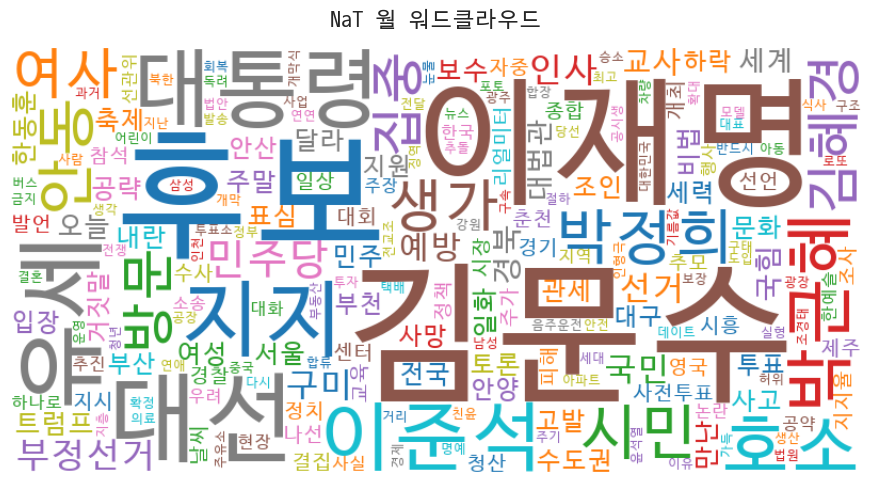

Saved ▶ wordclouds/wordcloud_NaT.png


In [23]:
# 4) 월별 워드클라우드 & 상위 단어 빈도 막대그래프 생성
months = sorted(df['month'].unique())

# 폴더 생성
os.makedirs('wordclouds', exist_ok=True)
os.makedirs('barcharts', exist_ok=True)

for m in months:
    df_m = df[df['month'] == m].copy()
    if df_m.empty:
        continue
    
    # (1) 제목 전처리
    df_m['tokens'] = df_m['title'].astype(str).apply(preprocess_title)
    
    # (2) 단어 빈도 집계
    all_words = [w for tok in df_m['tokens'] for w in tok]
    word_counts = Counter(all_words)
    
    # (3) 상위 20개 단어 막대그래프 (파일로 저장)
    top_n = 20
    top_items = word_counts.most_common(top_n)
    if top_items:
        words = [w for w, _ in top_items][::-1]
        freqs = [c for _, c in top_items][::-1]
        plt.figure(figsize=(8, 6))
        plt.barh(words, freqs)
        plt.title(f"{m} 월 — 상위 {top_n} 단어", pad=12, fontsize=14)
        plt.xlabel("빈도", fontsize=12)
        plt.tight_layout()
        # 저장
        barchart_fname = f"barcharts/barchart_{m}.png"
        plt.savefig(barchart_fname, dpi=300)
        plt.show()
        print(f"Saved ▶ {barchart_fname}")
    
    # (4) 워드클라우드 생성 (파일로 저장)
    if word_counts:
        wc = WordCloud(**WC_ARGS).generate_from_frequencies(word_counts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{m} 월 워드클라우드", pad=15, fontsize=16)
        plt.tight_layout()
        # 저장
        wc_fname = f"wordclouds/wordcloud_{m}.png"
        wc.to_file(wc_fname)
        plt.show()
        print(f"Saved ▶ {wc_fname}")


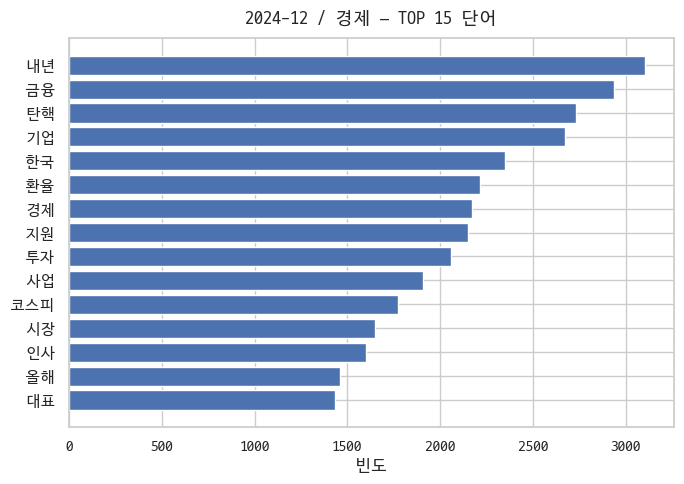

Saved ▶ section_barcharts/barchart_경제_2024-12.png


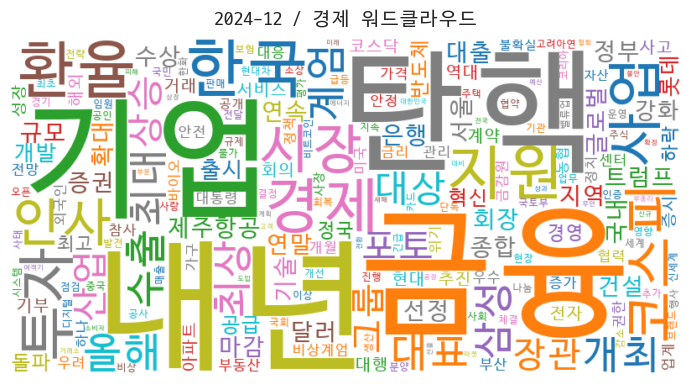

Saved ▶ section_wordclouds/wordcloud_경제_2024-12.png


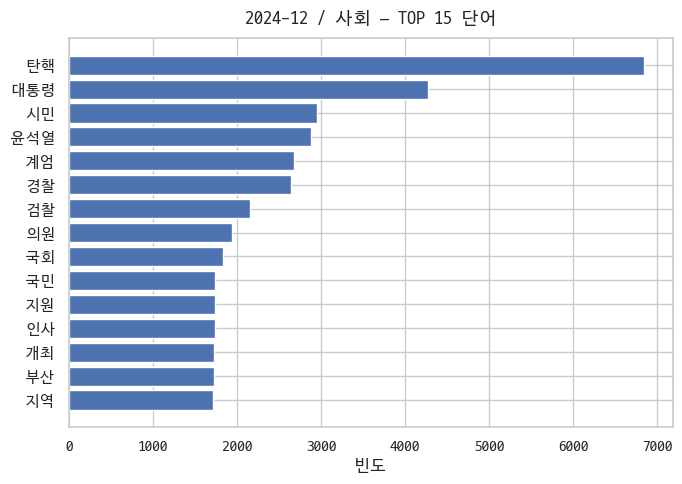

Saved ▶ section_barcharts/barchart_사회_2024-12.png


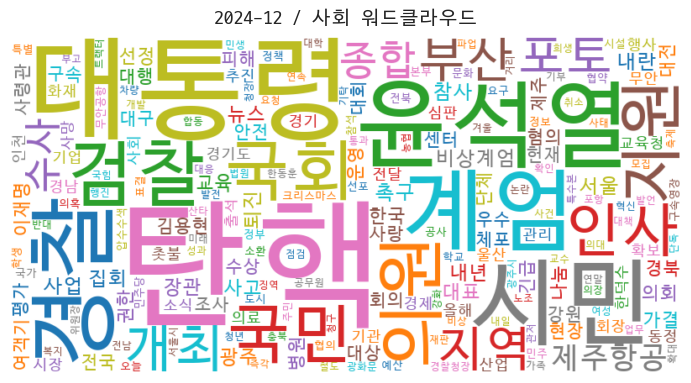

Saved ▶ section_wordclouds/wordcloud_사회_2024-12.png


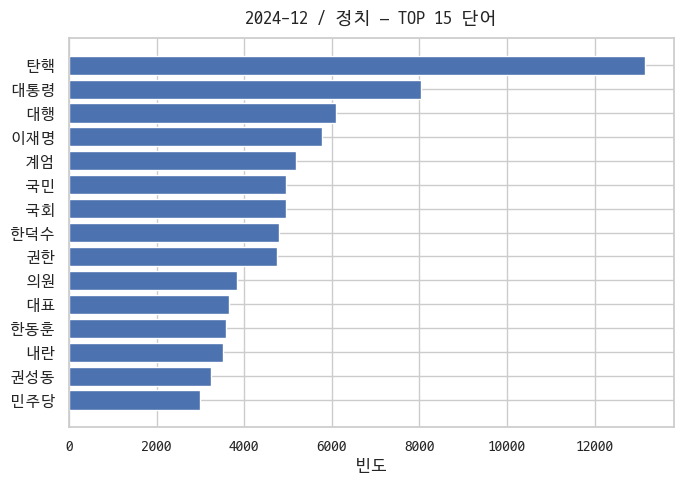

Saved ▶ section_barcharts/barchart_정치_2024-12.png


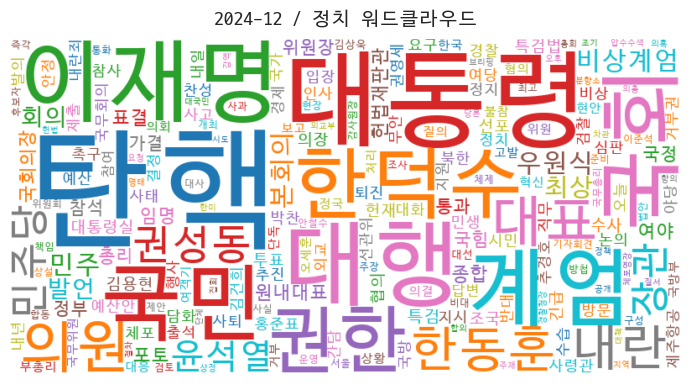

Saved ▶ section_wordclouds/wordcloud_정치_2024-12.png


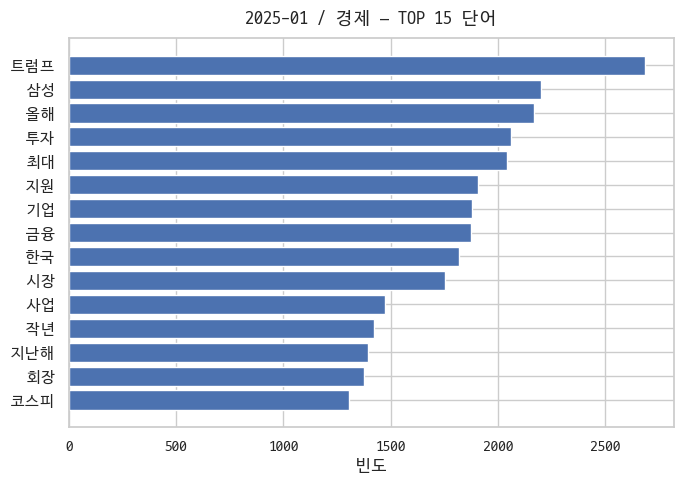

Saved ▶ section_barcharts/barchart_경제_2025-01.png


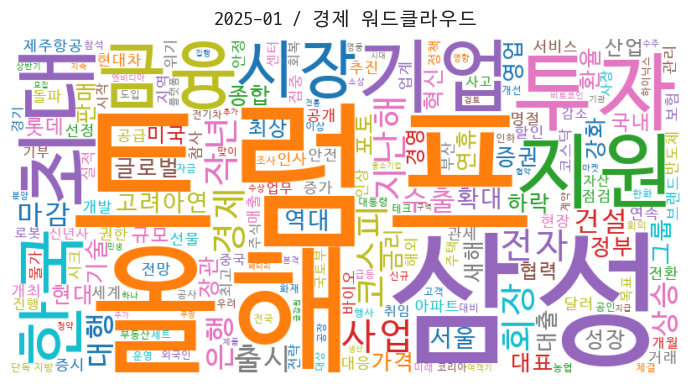

Saved ▶ section_wordclouds/wordcloud_경제_2025-01.png


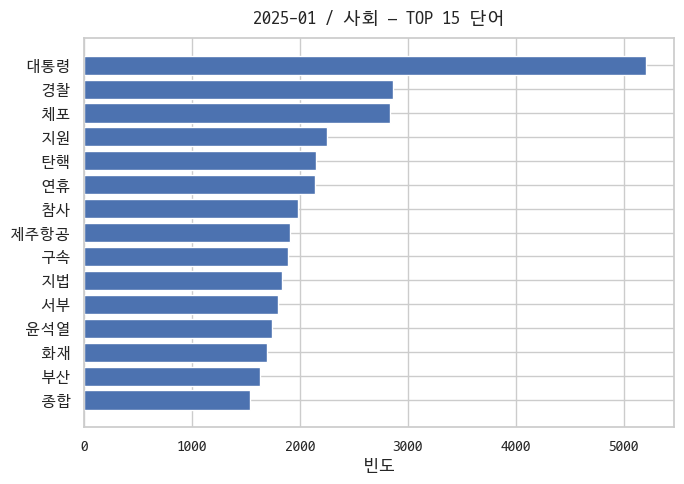

Saved ▶ section_barcharts/barchart_사회_2025-01.png


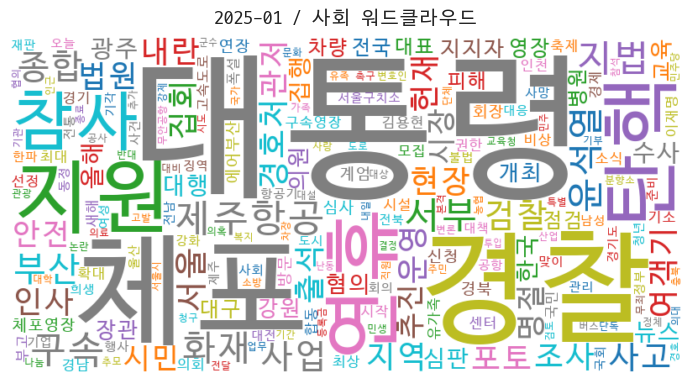

Saved ▶ section_wordclouds/wordcloud_사회_2025-01.png


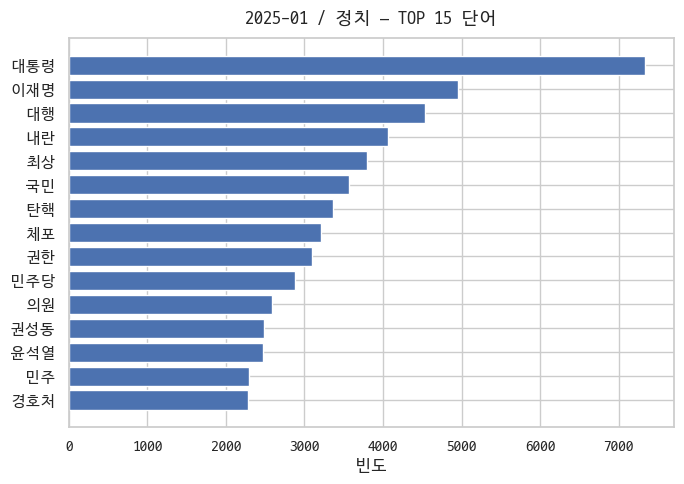

Saved ▶ section_barcharts/barchart_정치_2025-01.png


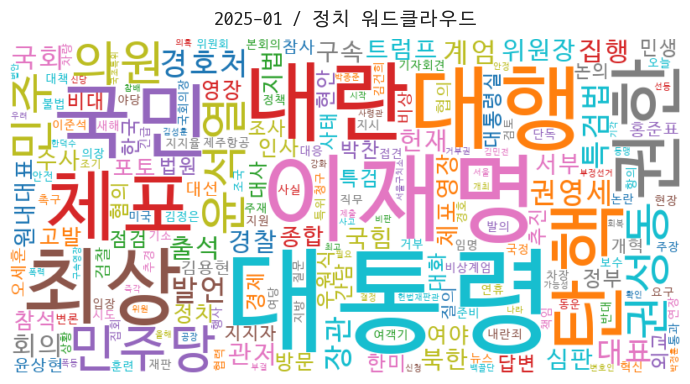

Saved ▶ section_wordclouds/wordcloud_정치_2025-01.png


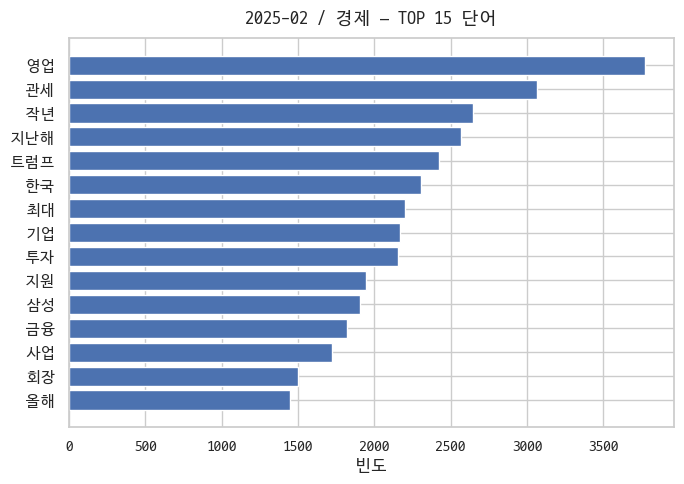

Saved ▶ section_barcharts/barchart_경제_2025-02.png


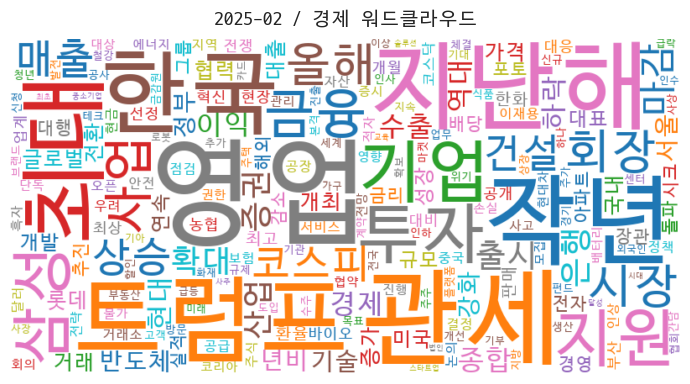

Saved ▶ section_wordclouds/wordcloud_경제_2025-02.png


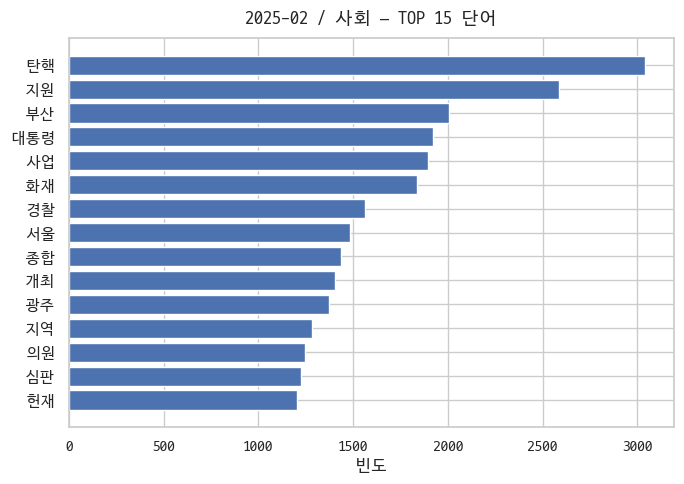

Saved ▶ section_barcharts/barchart_사회_2025-02.png


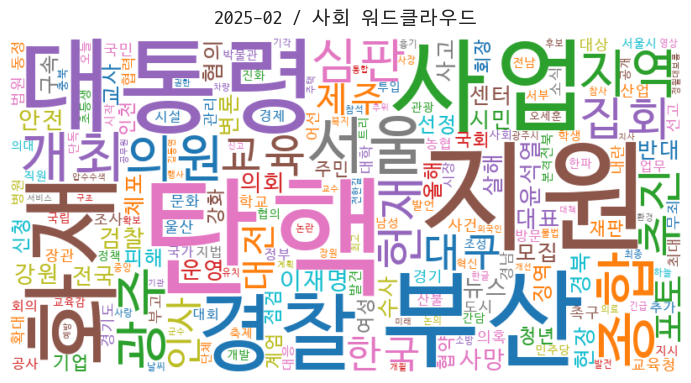

Saved ▶ section_wordclouds/wordcloud_사회_2025-02.png


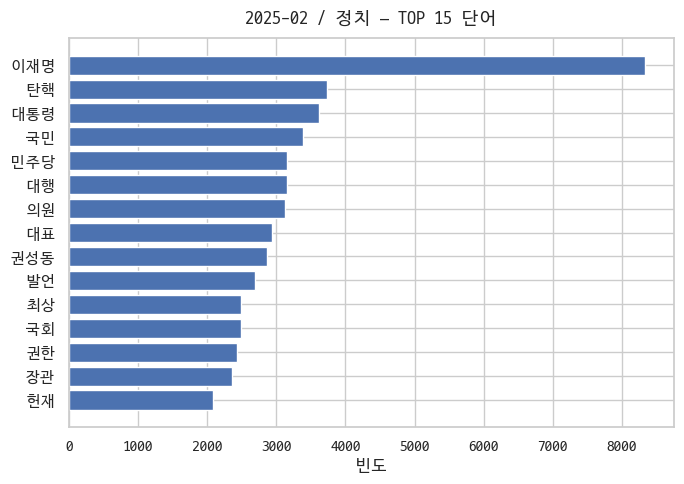

Saved ▶ section_barcharts/barchart_정치_2025-02.png


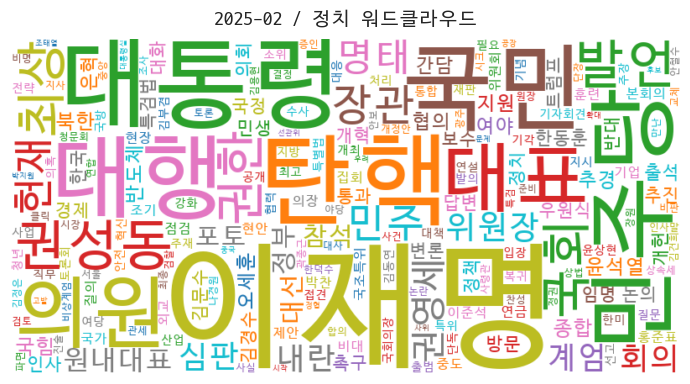

Saved ▶ section_wordclouds/wordcloud_정치_2025-02.png


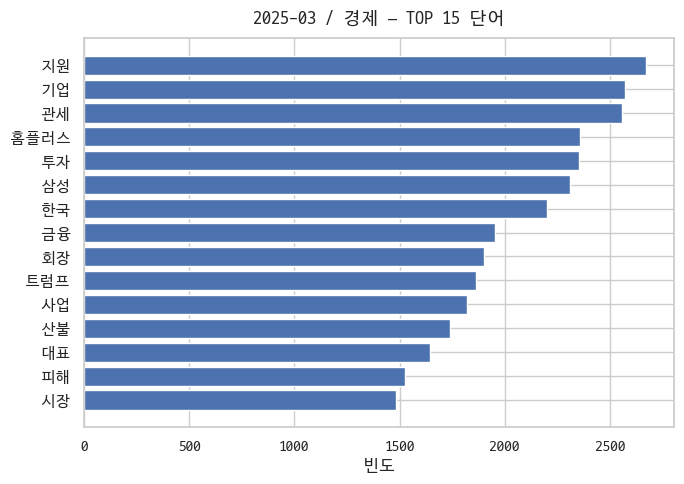

Saved ▶ section_barcharts/barchart_경제_2025-03.png


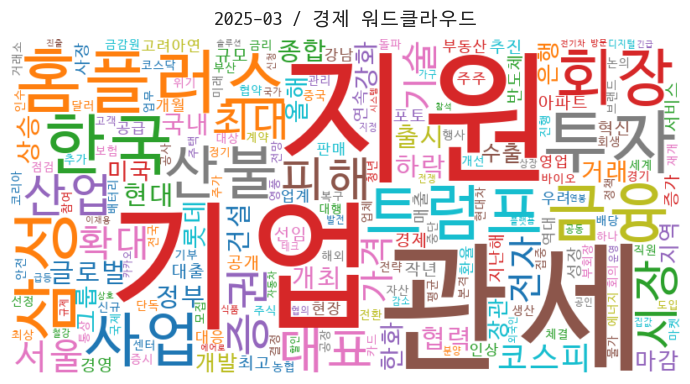

Saved ▶ section_wordclouds/wordcloud_경제_2025-03.png


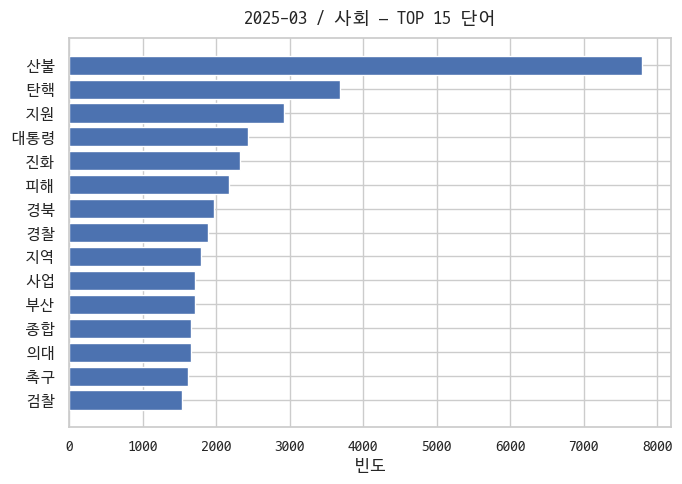

Saved ▶ section_barcharts/barchart_사회_2025-03.png


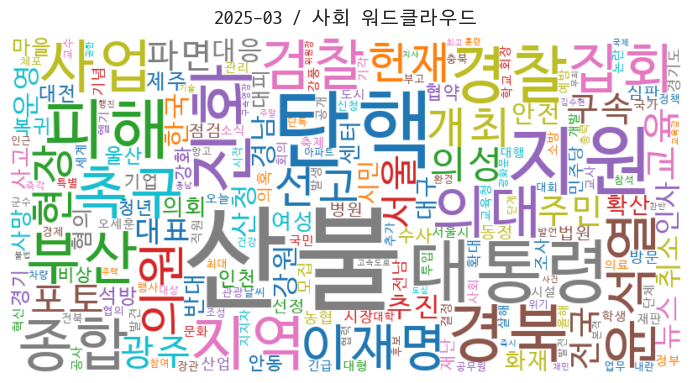

Saved ▶ section_wordclouds/wordcloud_사회_2025-03.png


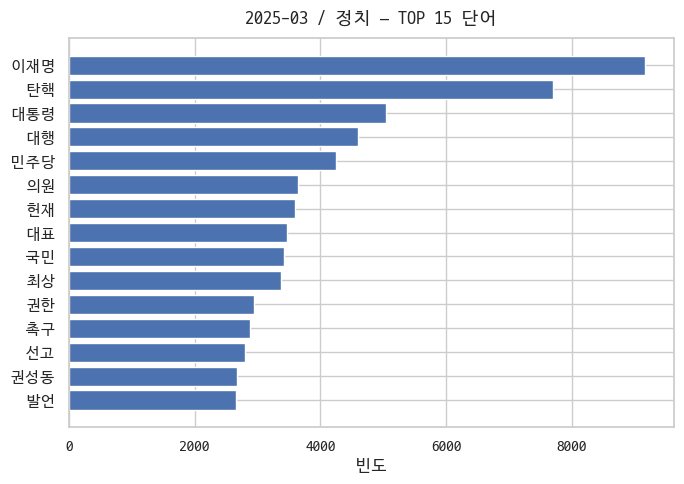

Saved ▶ section_barcharts/barchart_정치_2025-03.png


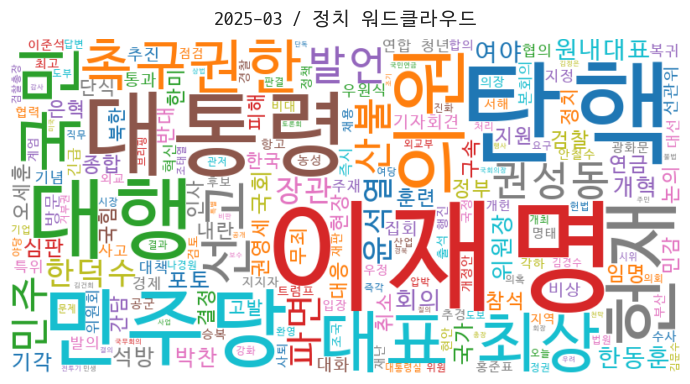

Saved ▶ section_wordclouds/wordcloud_정치_2025-03.png


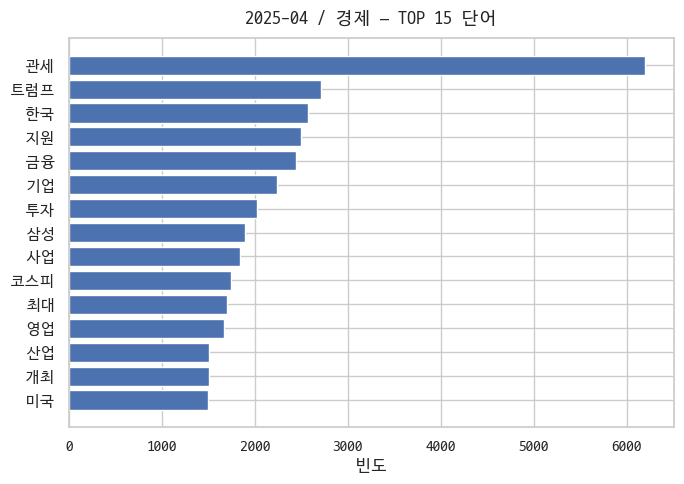

Saved ▶ section_barcharts/barchart_경제_2025-04.png


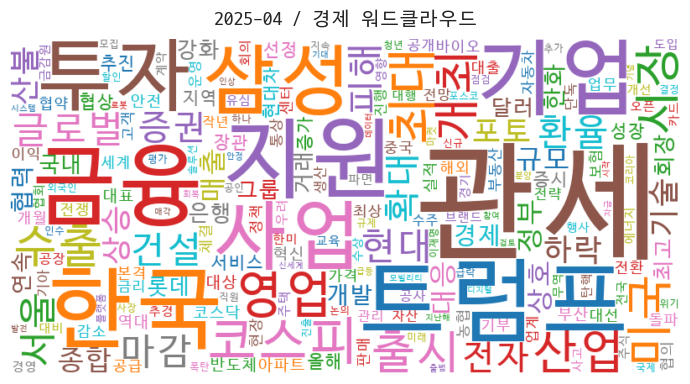

Saved ▶ section_wordclouds/wordcloud_경제_2025-04.png


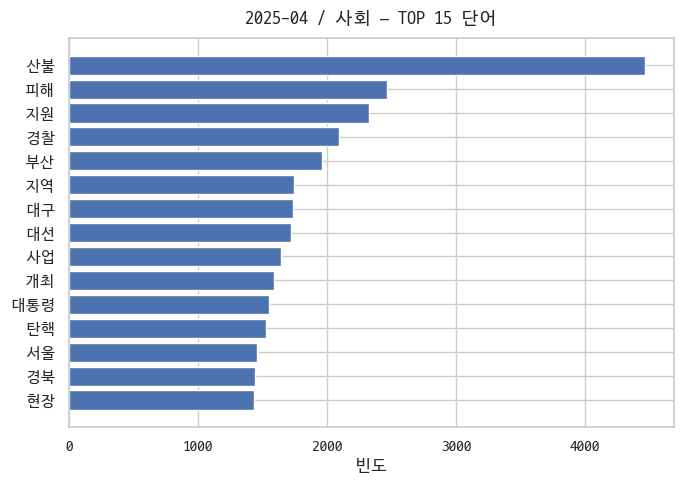

Saved ▶ section_barcharts/barchart_사회_2025-04.png


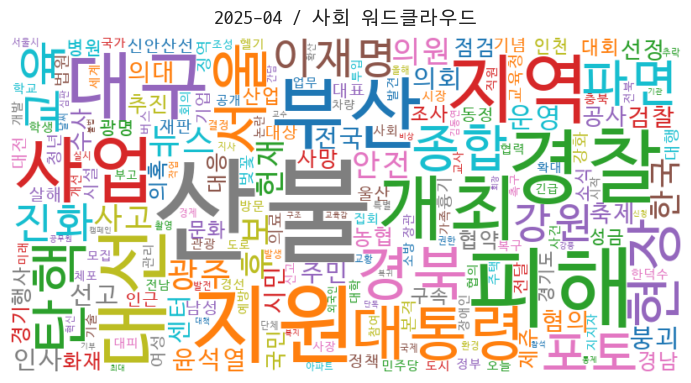

Saved ▶ section_wordclouds/wordcloud_사회_2025-04.png


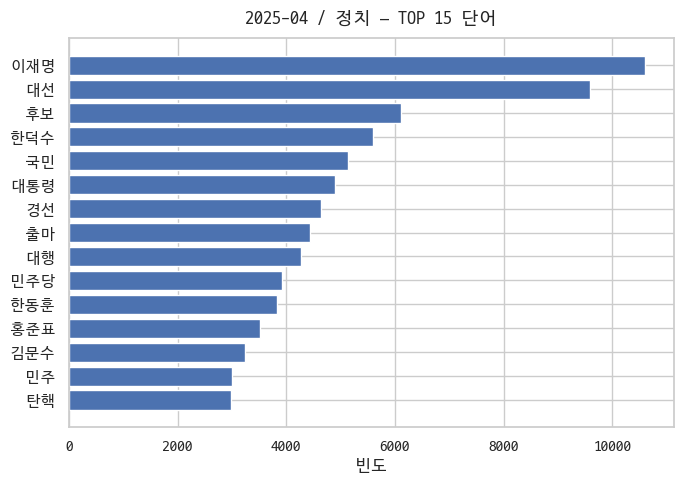

Saved ▶ section_barcharts/barchart_정치_2025-04.png


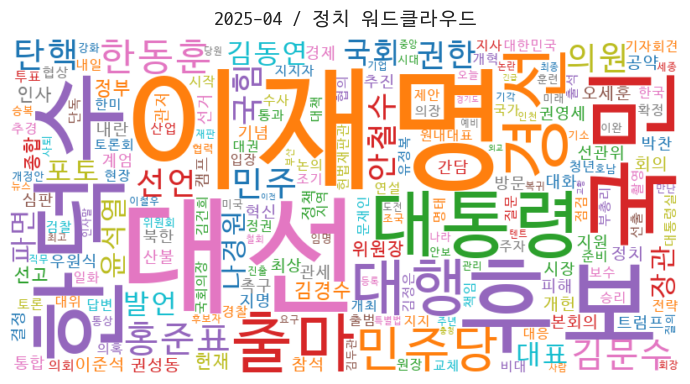

Saved ▶ section_wordclouds/wordcloud_정치_2025-04.png


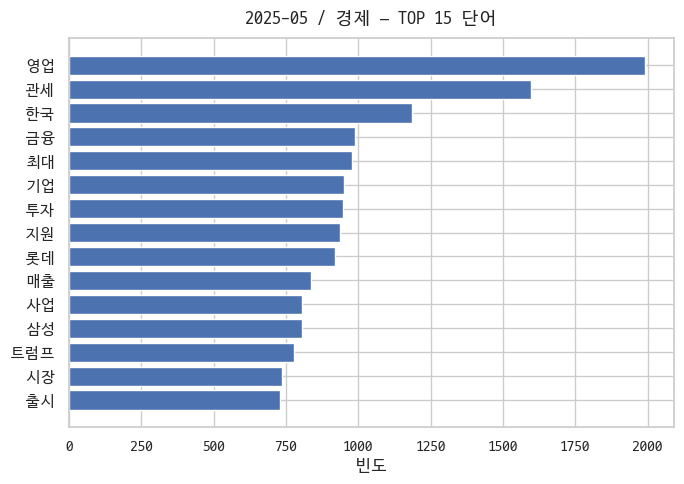

Saved ▶ section_barcharts/barchart_경제_2025-05.png


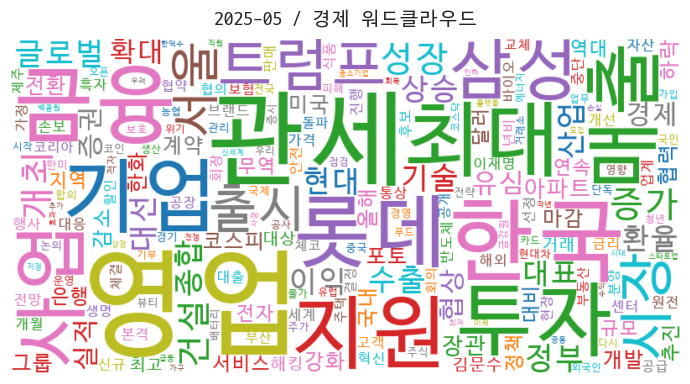

Saved ▶ section_wordclouds/wordcloud_경제_2025-05.png


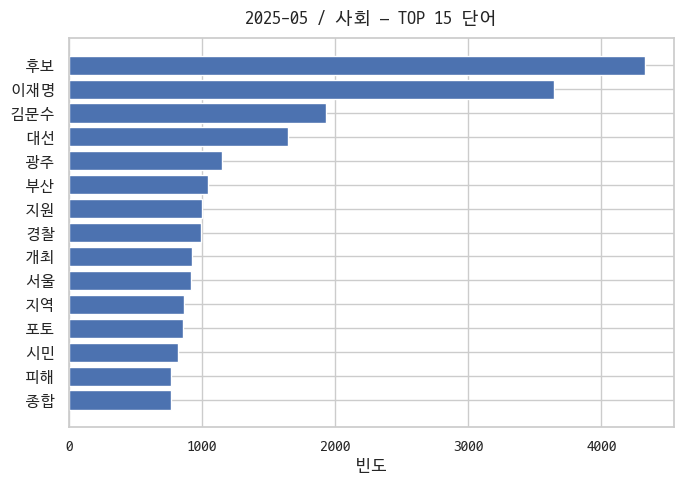

Saved ▶ section_barcharts/barchart_사회_2025-05.png


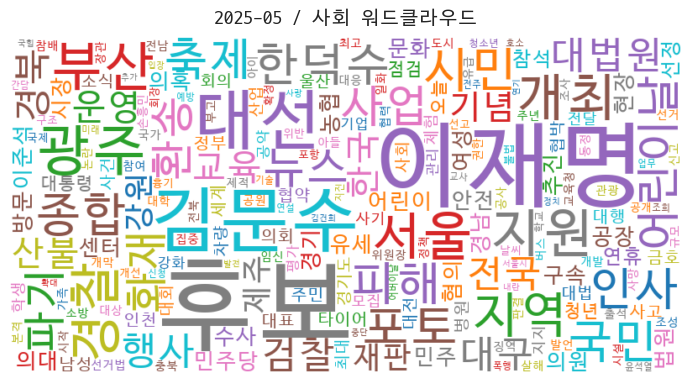

Saved ▶ section_wordclouds/wordcloud_사회_2025-05.png


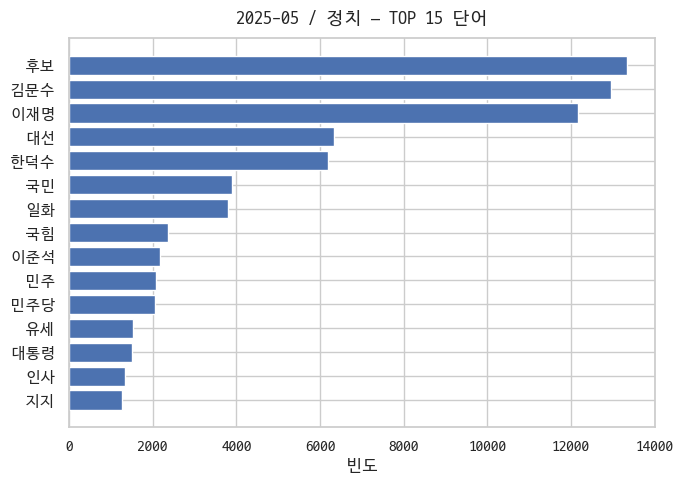

Saved ▶ section_barcharts/barchart_정치_2025-05.png


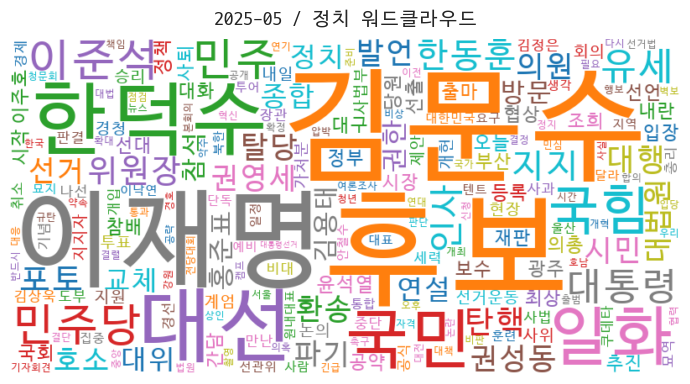

Saved ▶ section_wordclouds/wordcloud_정치_2025-05.png


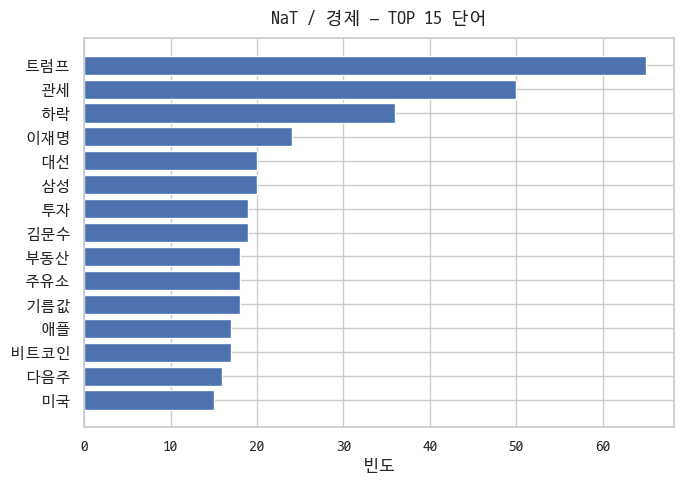

Saved ▶ section_barcharts/barchart_경제_NaT.png


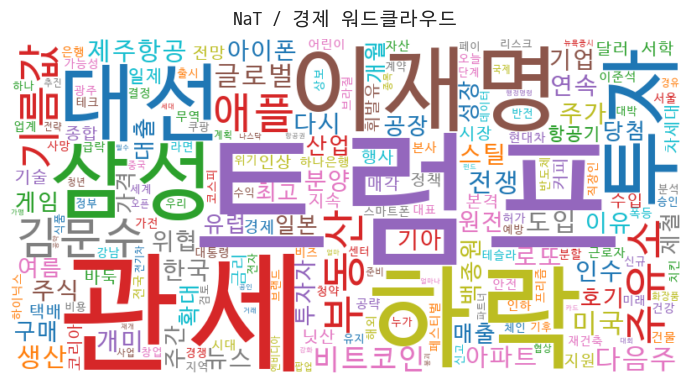

Saved ▶ section_wordclouds/wordcloud_경제_NaT.png


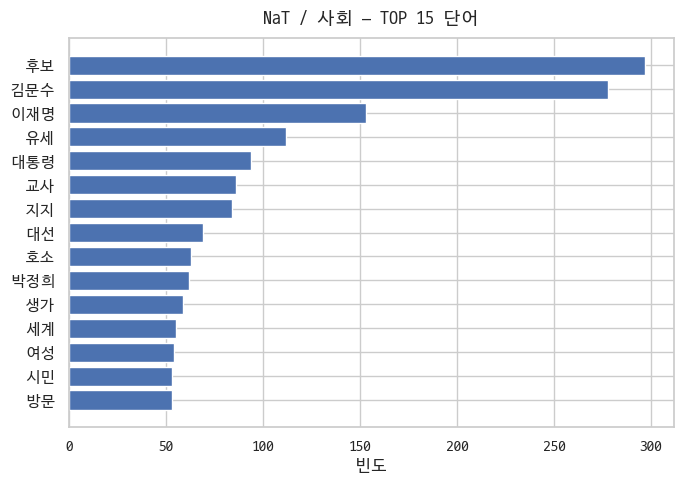

Saved ▶ section_barcharts/barchart_사회_NaT.png


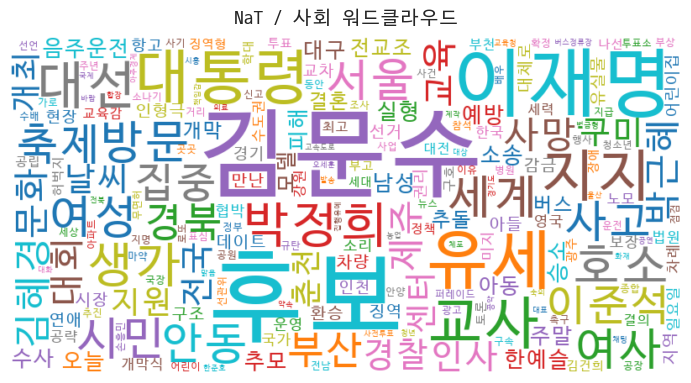

Saved ▶ section_wordclouds/wordcloud_사회_NaT.png


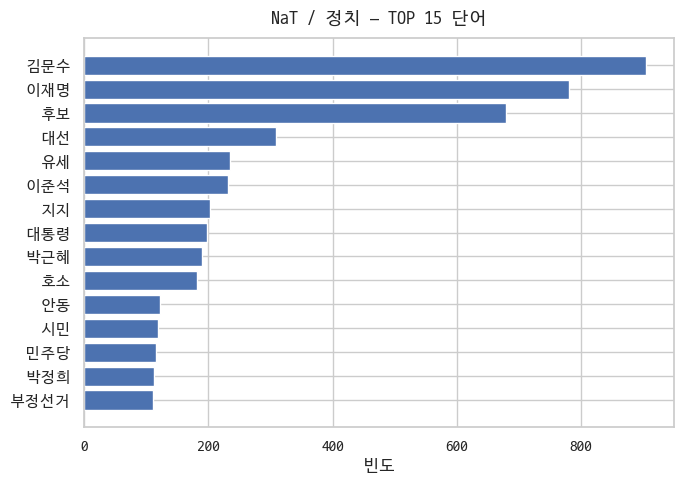

Saved ▶ section_barcharts/barchart_정치_NaT.png


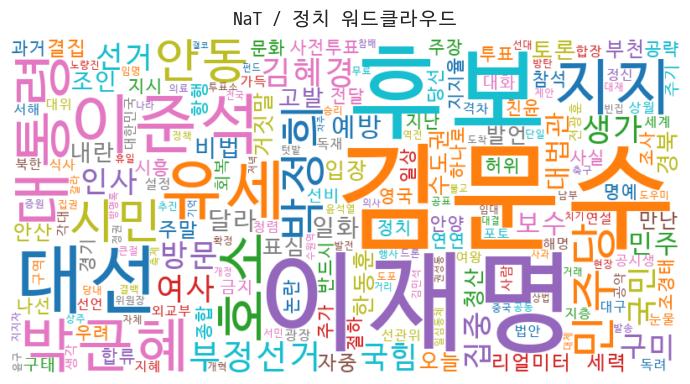

Saved ▶ section_wordclouds/wordcloud_정치_NaT.png


In [24]:
# 5) 섹션별·월별 워드클라우드 & 상위 단어 빈도 생성 (막대그래프 저장 포함)
os.makedirs('section_wordclouds', exist_ok=True)
os.makedirs('section_barcharts', exist_ok=True)

for m in months:
    df_m = df[df['month'] == m].copy()
    if df_m.empty:
        continue
    
    for sec, grp in df_m.groupby('section'):
        # (1) 제목 전처리
        grp['tokens'] = grp['title'].astype(str).apply(preprocess_title)
        
        # (2) 단어 빈도
        all_words = [w for tok in grp['tokens'] for w in tok]
        word_counts = Counter(all_words)
        
        if not word_counts:
            continue
        
        # (3) 섹션별 상위 15개 단어 막대그래프 (파일로 저장)
        top_items = word_counts.most_common(15)
        words = [w for w, _ in top_items][::-1]
        freqs = [c for _, c in top_items][::-1]
        plt.figure(figsize=(7, 5))
        plt.barh(words, freqs)
        plt.title(f"{m} / {sec} — TOP 15 단어", pad=10, fontsize=13)
        plt.xlabel("빈도")
        plt.tight_layout()
        # 저장
        sec_barchart_fname = f"section_barcharts/barchart_{sec}_{m}.png"
        plt.savefig(sec_barchart_fname, dpi=300)
        plt.show()
        print(f"Saved ▶ {sec_barchart_fname}")
        
        # (4) 섹션별 워드클라우드 (파일로 저장)
        wc = WordCloud(**WC_ARGS).generate_from_frequencies(word_counts)
        plt.figure(figsize=(8, 4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{m} / {sec} 워드클라우드", pad=10, fontsize=14)
        plt.tight_layout()
        wc_fname = f"section_wordclouds/wordcloud_{sec}_{m}.png"
        wc.to_file(wc_fname)
        plt.show()
        print(f"Saved ▶ {wc_fname}")


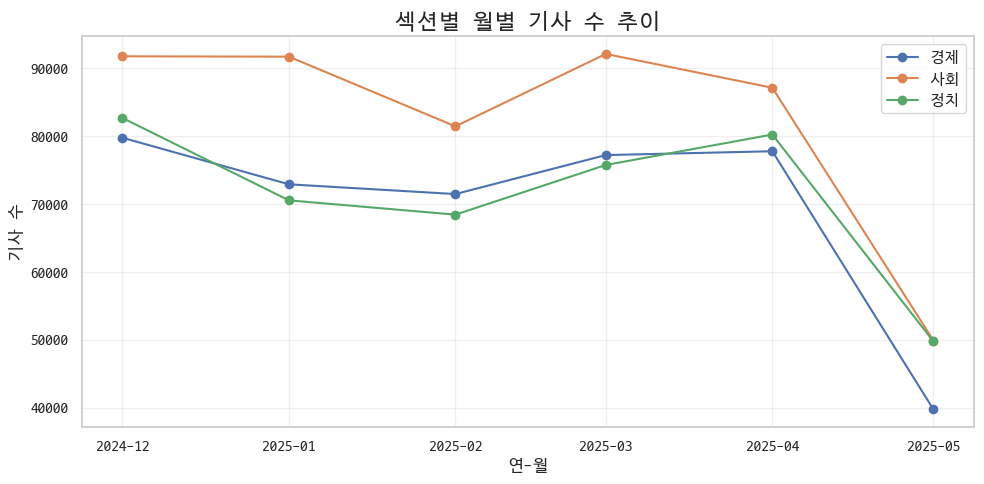

Saved ▶ time_series/section_time_series.png


In [25]:
# 6) 추가 인사이트: 섹션별·월별 기사 수 시계열 (이 그래프도 저장)
os.makedirs('time_series', exist_ok=True)

count_by_month = (
    df.groupby(['section', 'month'])
      .size()
      .reset_index(name='count')
)
count_by_month['month_dt'] = pd.to_datetime(count_by_month['month'], format='%Y-%m')

pivot = count_by_month.pivot(
    index='month_dt',
    columns='section',
    values='count'
).fillna(0)

plt.figure(figsize=(10, 5))
for sec in pivot.columns:
    plt.plot(pivot.index, pivot[sec], marker='o', label=sec)

plt.title("섹션별 월별 기사 수 추이", fontsize=16)
plt.xlabel("연-월", fontsize=12)
plt.ylabel("기사 수", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
# 저장
ts_fname = "time_series/section_time_series.png"
plt.savefig(ts_fname, dpi=300)
plt.show()
print(f"Saved ▶ {ts_fname}")


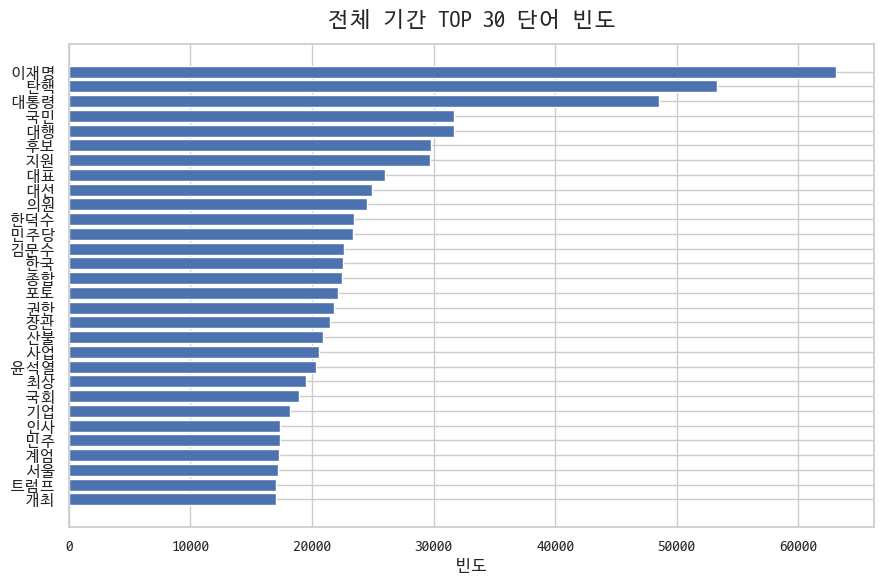

Saved ▶ overall/barchart_overall_top30.png


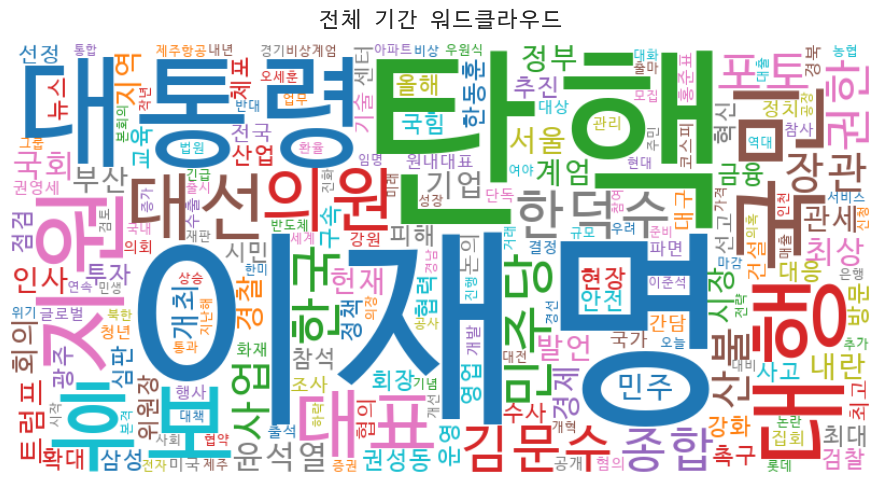

Saved ▶ overall/wordcloud_overall.png


In [26]:
# 7) 전체 기간 TOP 30 단어 빈도 & 워드클라우드 (막대그래프 저장)
os.makedirs('overall', exist_ok=True)

df['tokens_all'] = df['title'].astype(str).apply(preprocess_title)
all_words_total = [w for tok in df['tokens_all'] for w in tok]
counter_total = Counter(all_words_total)

# (1) 상위 30개 단어 막대그래프 (파일로 저장)
top30 = counter_total.most_common(30)
words30 = [w for w, _ in top30][::-1]
freqs30 = [c for _, c in top30][::-1]
plt.figure(figsize=(9, 6))
plt.barh(words30, freqs30)
plt.title("전체 기간 TOP 30 단어 빈도", fontsize=16, pad=12)
plt.xlabel("빈도", fontsize=12)
plt.tight_layout()
overall_barchart = "overall/barchart_overall_top30.png"
plt.savefig(overall_barchart, dpi=300)
plt.show()
print(f"Saved ▶ {overall_barchart}")

# (2) 전체 워드클라우드 (파일로 저장)
wc_total = WordCloud(**WC_ARGS).generate_from_frequencies(counter_total)
plt.figure(figsize=(10, 5))
plt.imshow(wc_total, interpolation='bilinear')
plt.axis('off')
plt.title("전체 기간 워드클라우드", fontsize=16, pad=12)
plt.tight_layout()
overall_wc = "overall/wordcloud_overall.png"
wc_total.to_file(overall_wc)
plt.show()
print(f"Saved ▶ {overall_wc}")
